# Bridge Analysis

This notebook demonstrates the use of `PyCBA` in conducting moving load and other analyses relevant to bridge analysis.

In [1]:
# This cell not necessary once pycba is installed
import sys
sys.path.append("../../..")

In [2]:
import pycba as cba
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Example 1 - Moving Load Envelope

This example shows the basic interface for moving a vehicle across the bridge.

Consider a two-span continuous bridge, 50 m long:

In [3]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]

and a three-axle vehicle with a 6 t steer axle, 6 m spacing back to the tandem of 12 t axles each with spacing 1.2 m:

In [4]:
axle_spacings = np.array([6, 1.2])
axle_weights = np.array([6, 12, 12]) * 9.81  # t to kN

Now define the `bridge_analysis` object and add the bridge definition and vehicle definitions:

In [5]:
bridge_analysis = cba.BridgeAnalysis()
bridge = bridge_analysis.add_bridge(L, EI, R)
vehicle = bridge_analysis.add_vehicle(axle_spacings, axle_weights)

Examine the vehicle at a single position, when the front axle is at 30.0 m say:

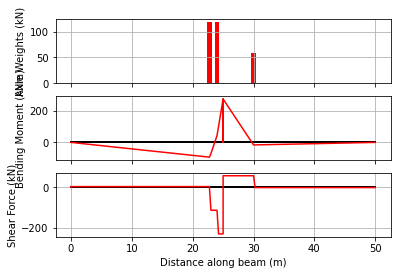

In [6]:
bridge_analysis.static_vehicle(30.0, True)

Now we run the vehicle over the bridge, returning the envelope of results. When run as a python script, the `matplotlib` figure will animate each result when `plot_all=True`.

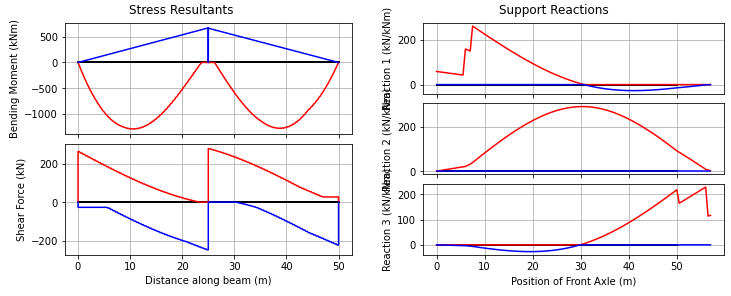

In [7]:
bridge_analysis.run_vehicle(0.5, plot_env=True, plot_all=False)

Alternatively, using the `reverse()` method, we can do an analysis for the vehicle travelling in the reverse direction.

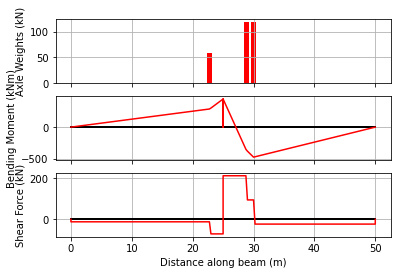

In [8]:
vehicle.reverse()
bridge_analysis.static_vehicle(30.0, True)

## Example 2 - Critical Values and Positions

In [9]:
L = [37]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0]

In [10]:
bridge = cba.BeamAnalysis(L, EI, R)
bridge.npts = 500  # Use more points along the beam members
vehicle = cba.VehicleLibrary.get_m1600(6.25)
bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
env = bridge_analysis.run_vehicle(0.1)

From the envelope, we can extract the critical values of load effects, where they are located, and the vehicle position that caused it:

In [11]:
cvals = bridge_analysis.critical_values(env)

and so if we are interested in the maximum bending moment in particular, we can interogate the results as follows:

In [12]:
pos = cvals["Mmax"]["pos"][0]
at = cvals["Mmax"]["at"]
val = cvals["Mmax"]["val"]
print(f"Max moment is {val} kNm at {at:.2f} m when front axle position is {pos} m")

Max moment is 7809.3 kNm at 20.35 m when front axle position is 29.1 m


and confirm the results with a static analysis with the vehicle at that position:

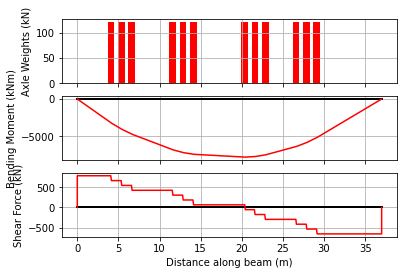

In [13]:
bridge_analysis.static_vehicle(pos, True);

## Example 3 - Access Assessment

This example considers the relative load effects between a reference vehicle and another vehicle. This type of analysis is commonly done to assess whether a new vehicle type would impose more onerous load effects on a bridge than some existing reference vehicle.

In [14]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]
bridge = cba.BeamAnalysis(L, EI, R)

### Using `VehicleLibrary()`

Here we use a suite of reference vehicles (the Australian ABAG B-doubles) to create a "super-envelope": an envelope of the load effect envelopes from each of the 3 reference vehicles.

Firstly, obtain the vehicle from the `VehicleLibrary` and analyze for the envelope, appending it to the list of envelopes.

In [15]:
envs = []
for i in range(3):
    vehicle = cba.VehicleLibrary.get_abag_bdouble(i)
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    envs.append(bridge_analysis.run_vehicle(0.5))

Next, create a new zero-like envelope and augment it with the stored envelopes, such that the result is the envelope of envelopes:

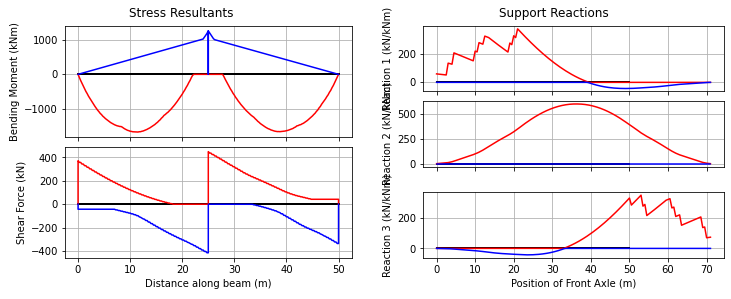

In [16]:
envenv = cba.Envelopes.zero_like(envs[0])
for e in envs:
    envenv.augment(e)
bridge_analysis.plot_envelopes(envenv)

Now analyze the permit application vehicle; here just taking an example vehicle from the `VehicleLibrary`:

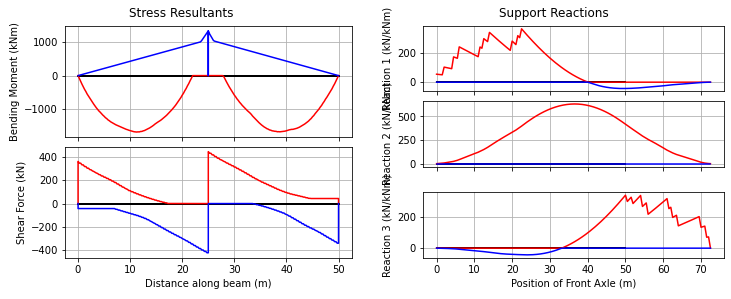

In [17]:
vehicle = cba.VehicleLibrary.get_example_permit()
bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
trial_env = bridge_analysis.run_vehicle(0.5, True)

And we can plot the ratios of trial to reference envelopes

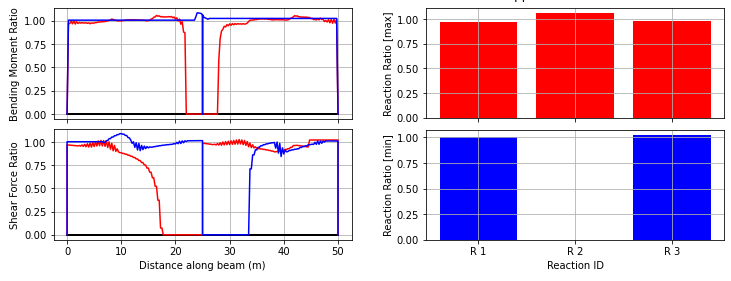

In [18]:
envr = bridge_analysis.envelopes_ratios(trial_env, envenv)
bridge_analysis.plot_ratios(envr)

As can be seen in this case, the central support reaction is greater than 1.0, as is the hogging moment (by about 7%). This vehicle is unlikely to be granted a permit as a result.

### Using `.from_vehicle_sequence()`

Using the `Vehicle.from_vehicle_sequence` method we create vehicles as a series of `Vehicle` objects behind one another at different spacings. 
Here, we will explore different prime mover + platform trailer combinations commonly adopted in "superload" transport convoys.

In [19]:
prime_mover = cba.Vehicle(axle_spacings=np.array([3.2,1.2]),
                          axle_weights=np.array([6.5,9.25,9.25]))
platform_trailer = cba.Vehicle(axle_spacings=np.array([1.8,]*9),
                               axle_weights=np.array([12]*10))

Three different spacing combinations is explored for convoy comprising of two front prime movers followed by two platform trailers and then two back prime movers.

In [20]:
inter_spaces = [np.array([5.0,6.3,8.0,6.0,4.8]),
               np.array([4.8,6.0,7.5,6.0,5.0]),
               np.array([5.0,6.3,8.0,6.3,5.0])]

Now, similar to the above, envelopes are run and augmented.

In [21]:
envs = []
for s in inter_spaces:
    vehicle = cba.Vehicle.from_vehicle_sequence([prime_mover]*2 + [platform_trailer]*2 + [prime_mover]*2,s)
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    envs.append(bridge_analysis.run_vehicle(0.1))

In [22]:
envenv = cba.Envelopes.zero_like(envs[0])
for e in envs:
    envenv.augment(e)
bridge_analysis.plot_envelopes(envenv)

ValueError: Cannot augment with an inconsistent envelope